# User similarity: Modeling patterns in allrecipes members' food preferences using recipe ingredients  
Using the collection of recipes that each member has made and 'favorite'd, I can characterize members' tastes and find similar users.  
## Features
- Dimensionality reduction, topic modeling of tokenized ingredient features using NMF, PCA (tSVD)
- Visualize components 
- Pairwise user similiarity calculations

In [289]:
import pymongo 
import cPickle
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

client = pymongo.MongoClient("mongodb://localhost/27017")

ar_db = client.allrecipes

ar_db.members.find_one().keys()

[u'nutrition',
 u'followers_dict',
 u'reviews_dict',
 u'following_id_list',
 u'madeits_recipe_id_list',
 u'favorites_dict',
 u'reviews_recipe_id_list',
 u'nutrition_avg_vals',
 u'following_dict',
 u'member_ID',
 u'favorites_recipe_id_list',
 u'_id',
 u'aboutme',
 u'madeits_dict',
 u'followers_id_list']

In [290]:
member_recipes = [(a['member_ID'], a['madeits_recipe_id_list']+a['favorites_recipe_id_list']) for a in ar_db.members.find()]

In [7]:
member_recipes[0]

(u'17117019', [u'26297', u'26297', u'10462', u'10462'])

In [10]:
# Previously tokenized recipe corpus
# dict of recipe_ID:list of preprocessed, tokenized ingredient phrases
with open('../data/allrecipes/recipe_tokens.pkl', 'rb') as f: 
    recipe_tokens = cPickle.load(f)

In [12]:
recipe_tokens.items()[0]

(u'73468',
 [[u'water', u',', u'divided'],
  [u'plain', u'yogurt', u'with', u'active', u'cultures'],
  [u'dry', u'milk', u'powder']])

In [24]:
member_ingredients = [(a[0], [recipe_tokens.get(b, "") for b in a[1]]) for a in member_recipes]

In [25]:
member_ingredients[56]

(u'17668201',
 [[[u')', u'package', u'egg', u'noodles'],
   [u'lean', u'ground', u'beef'],
   [u'.75', u'ounce', u')', u'packet', u'dry', u'brown', u'gravy', u'mix'],
   [u')', u'package', u'cream', u'cheese'],
   [u')', u'can', u'chopped', u'mushrooms', u',', u'with', u'liquid'],
   [u'milk'],
   [u')', u'container', u'sour', u'cream'],
   [u')', u'cans', u'condensed', u'cream', u'of', u'mushroom', u'soup']],
  [[u'ground', u'beef'],
   [u'chunky', u'salsa'],
   [u')', u'can', u'whole', u'kernel', u'corn', u',', u'drained'],
   [u'creamy', u'salad', u'dressing'],
   [u'chili', u'powder'],
   [u'crushed', u'tortilla', u'chips'],
   [u'Colby', u'cheese']],
  [[u'Italian-style', u'salad', u'dressing'],
   [u'soy', u'sauce'],
   [u'pepper'],
   [u'boneless', u'pork', u'chops']],
  [[u'lean', u'ground', u'beef'],
   [u'barbeque', u'sauce'],
   [u'dried', u'minced', u'onion'],
   [u')', u'package', u'refrigerated', u'biscuit', u'dough'],
   [u'shredded', u'Cheddar', u'cheese']],
  [[u')', u

In [26]:
len(member_ingredients)

1430

In [34]:
member_recipes[0]

(u'17117019', [u'26297', u'26297', u'10462', u'10462'])

In [106]:
# collections.Counter([len(a[1]) for a in member_recipes])

In [107]:
# collections.Counter([len(a[1]) for a in member_ingredient_tokens])

In [27]:
# stackoverflow solution for flattening lists of lists 
def flatten(items, seqtypes=(list, tuple)):
    for i, x in enumerate(items):
        while i < len(items) and isinstance(items[i], seqtypes):
            items[i:i+1] = items[i]
    return items

In [28]:
member_ingredient_tokens = [(a[0], " ".join(flatten(a[1]))) for a in member_ingredients]

In [29]:
member_ingredient_tokens[0]

(u'17117019',
 u') package rotini pasta vegetable oil fresh lime juice chili powder , or to taste ground cumin salt garlic , crushed whole kernel corn ) can black beans , drained and rinsed diced green bell pepper diced red bell pepper fresh cilantro leaves chopped roma tomatoes ) package rotini pasta vegetable oil fresh lime juice chili powder , or to taste ground cumin salt garlic , crushed whole kernel corn ) can black beans , drained and rinsed diced green bell pepper diced red bell pepper fresh cilantro leaves chopped roma tomatoes white sugar baking powder all-purpose flour shortening egg salt ground cinnamon fresh blueberries white sugar cornstarch white sugar baking powder all-purpose flour shortening egg salt ground cinnamon fresh blueberries white sugar cornstarch')

In [41]:
X = [a[1] for a in member_ingredient_tokens]

In [40]:
# instantiate stemmer, analyzer 
stemmer = nltk.SnowballStemmer("english")
analyzer = TfidfVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


# instantiate vectorizer for ingredients
vectorizer = TfidfVectorizer(stop_words='english', 
                             strip_accents='ascii',
                             analyzer=stemmed_words)


In [44]:
X_vectorized = vectorizer.fit_transform(X)

In [45]:
features = vectorizer.get_feature_names()

In [109]:
nmf = NMF(n_components = 2)

In [111]:
# observe latent topics with NMF
W = nmf.fit_transform(X_vectorized)
H = nmf.components_
n_top_words = 25
print("Reconstruction error: %f") %(reconst_mse(X_vectorized, W, H))
for topic_num, topic in enumerate(H):
    print("\nTopic %d:" % topic_num)
    print(" ".join([features[i] \
            for i in topic.argsort()[:-n_top_words - 1:-1]]))

Reconstruction error: 0.000153

Topic 0:
pepper chop ground salt and onion garlic to tast fresh can chees black oil dri slice sauc chicken minc or oliv dice into cut tomato

Topic 1:
sugar white butter flour egg bake purpos all extract vanilla salt milk ground powder soda soften cinnamon cream chocol brown confection packag water melt pack


### "Sweet (dessert)" and "savory" appear to be distinct latent topics in members preferences of recipes.  
What are the clustering characteristics like?  Reduce dimensions and observe clustering.  Equivalent to Latent Semantic Analysis.  

In [148]:
# truncated svd is used instead of pca in sklearn, for sparse matrices; 
# tsvd does not center data before svd.  
svd = TruncatedSVD(n_components=2, n_iter=20)

In [206]:
X_tsvd = svd.fit_transform(X_vectorized)

In [207]:
svd.explained_variance_ratio_

array([ 0.132527  ,  0.09593158])

In [208]:
# First two components captures ~1/4 of variance 

In [209]:
X_tsvd.shape

(1430, 2)

In [210]:
plt.scatter?

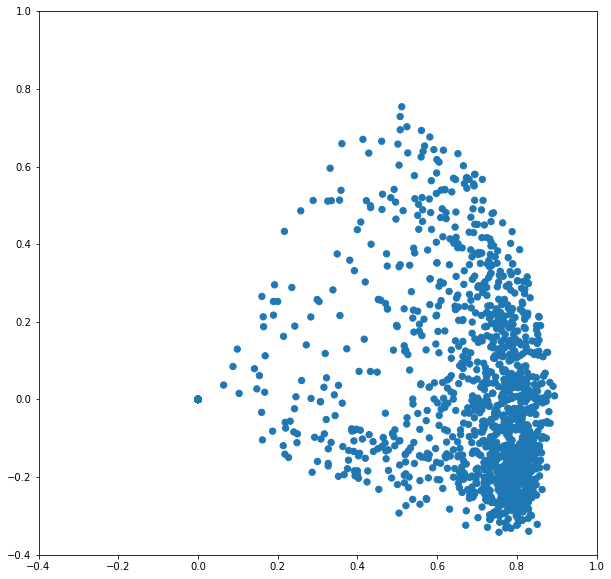

In [211]:
plt.figure(figsize=(10,10))
plt.axis([-.4, 1, -.4, 1])
plt.scatter(X_tsvd[:,0], X_tsvd[:,1], s=(40,40))


#### Observation: 
In this visualization, the first component (x axis) does not appear to have greater variance than the second (y axis).  This should not be the case as truncated SVD ought to order the singular values.  Is it because the sparse matrix wasn't normalized before fitting?  

In [246]:
# normalize sparse matrix 
from sklearn.preprocessing import normalize
X_normalized = normalize(X_vectorized, norm='l1', axis=1)
ntsvd = TruncatedSVD(n_components=2, n_iter=20)

In [247]:
X_ntsvd = ntsvd.fit_transform(X_normalized)

In [248]:
ntsvd.explained_variance_ratio_

array([ 0.06720709,  0.09081654])

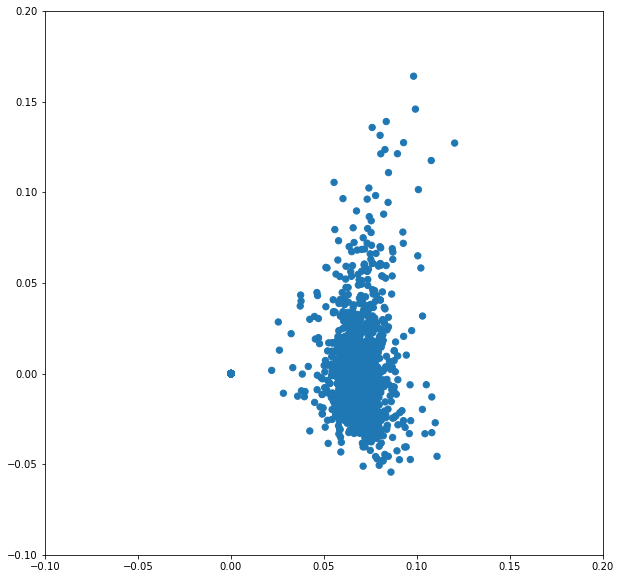

In [288]:
# Hmm, singluar values aren't ordered.  It seems to happen for n_components = 2.  This must be a bug.  
plt.figure(figsize=(10,10))
plt.axis([-.1, .2, -.1, .2])
plt.scatter(X_ntsvd[:,0], X_ntsvd[:,1], s=(40,40))


## Clustering with k means 

In [277]:
n_clusters = 3

In [279]:
 km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=1, random_state = 42)

In [280]:
km.fit(X_vectorized)

Initialization complete
Iteration  0, inertia 1006.772
Iteration  1, inertia 649.067
Iteration  2, inertia 646.957
Iteration  3, inertia 646.655
Iteration  4, inertia 646.529
Iteration  5, inertia 646.336
Iteration  6, inertia 646.184
Iteration  7, inertia 646.069
Iteration  8, inertia 646.051
Iteration  9, inertia 646.047
Converged at iteration 9: center shift 0.000000e+00 within tolerance 1.980771e-08


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=1)

In [281]:
km.labels_.shape

(1430,)

In [282]:
X_tsvd.shape

(1430, 2)

In [283]:
km.labels_

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

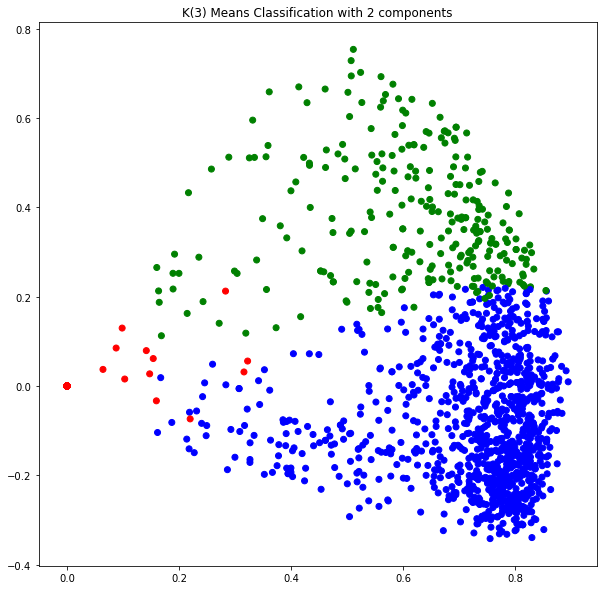

In [299]:
# Visualize tsvd and k means 

plt.figure(figsize=(10,10))
colormap = np.array(['red', 'green', 'blue', 'black','yellow'])[:n_clusters]
plt.scatter(X_tsvd[:,0], X_tsvd[:,1], c=colormap[km.labels_])
plt.title('K(3) Means Classification with 2 components')

Initialization complete
Iteration  0, inertia 14.492
Iteration  1, inertia 10.647
Iteration  2, inertia 10.601
Iteration  3, inertia 10.565
Iteration  4, inertia 10.500
Iteration  5, inertia 10.388
Iteration  6, inertia 10.351
Iteration  7, inertia 10.344
Iteration  8, inertia 10.343
Iteration  9, inertia 10.342
Iteration 10, inertia 10.341
Iteration 11, inertia 10.341
Iteration 12, inertia 10.341
Iteration 13, inertia 10.341
Iteration 14, inertia 10.341
Iteration 15, inertia 10.340
Converged at iteration 15: center shift 0.000000e+00 within tolerance 3.188905e-10


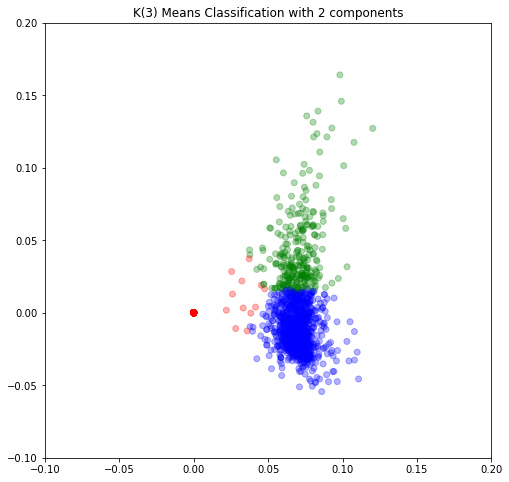

In [346]:
# Visualize normalized tsvd and k(3) means 

km.fit(X_normalized)

plt.figure(figsize=(8,8))
colormap = np.array(['red', 'green', 'blue', 'black','yellow'])[:n_clusters]
plt.axis([-.1, .2, -.1, .2])
plt.scatter(X_ntsvd[:,0], X_ntsvd[:,1], c=colormap[km.labels_], alpha=.3)
plt.title('K(3) Means Classification with 2 components')

In [362]:
vectorizer.get_feature_names()[X_ntsvd.argmin()]

u'hamburg'

In [358]:
X_ntsvd.argmax()

679

## Try using pca: 

In [312]:
# Transform sparse matrix into dense 
X_dense = X_normalized.todense()

pca = PCA(n_components=5)

X_pca = pca.fit_transform(X_dense)

pca.explained_variance_ratio_

array([ 0.09096114,  0.06852913,  0.02459307,  0.02231545,  0.01848195])

In [332]:
# Aha! PCA algorithm orders the components as it should.  

## Visualizing NMF results

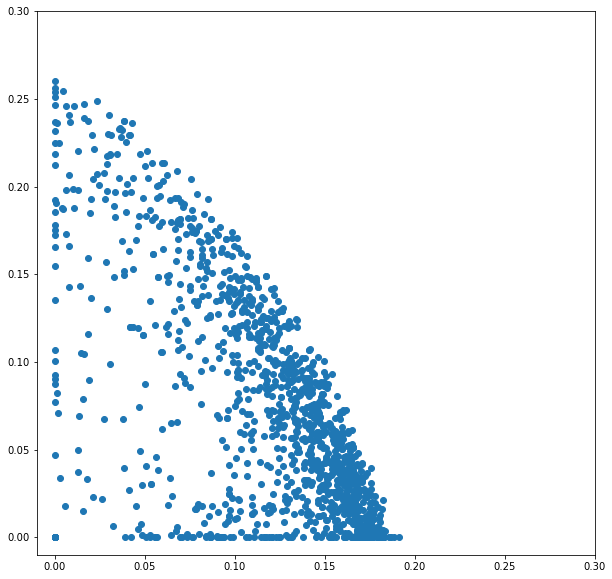

In [291]:
plt.figure(figsize=(10,10))
plt.axis([-.01,.3,-.01,.3])
plt.scatter(W[:,0], W[:,1])

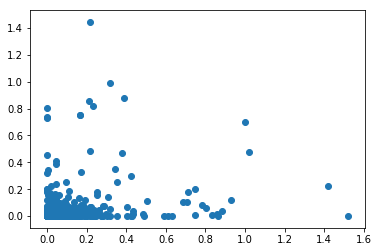

In [214]:
plt.scatter(H[0,:], H[1,:])

# User-similarity recommender system
Moving on to constructing a recommendation engine.  User similarity can be used to suggest connecting with people with similar tastes.  This may not have much utility for promoting health, but done for posterity.  
## Take a user's favorites and made-its recipes, get 5 most similar users.  
1. Tfidf-vectorize list of ingredients per user (done already) 
1. Compute pairwise similarity over users
1. Find 5 most similar users using several metrics

In [392]:
# Use sklearn's pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances

In [365]:
X_vectorized.shape

(1430, 2559)

In [369]:
# cosine similarity as metric
user_similarity_cosine = pairwise_distances(X_vectorized, metric='cosine')

In [372]:
user_similarity_cosine.shape

(1430, 1430)

In [393]:
# Get index of 5 most similar members
user_similarity_cosine[1].argsort()[:-1][:6]

array([   1,  249,  689,  669,  192, 1209])

## Quick observation of what these members have made: 

In [384]:
ar_db.members.find_one(member_ingredients[1][0])['madeits_dict']

{u' BBQ NY Strip ': u'86801',
 u' Beefy Baked Ravioli ': u'87624',
 u' Blackberry Spinach Salad ': u'41637',
 u' Broth Marinated BBQ Steak ': u'21037',
 u' Citrus Carrot Salad ': u'233078',
 u' Creamy Tortellini Carbonara ': u'216572',
 u' Family Casserole ': u'46859',
 u' Garlic Chicken Fried Brown Rice ': u'78144',
 u' Grilled Cheese De Mayo ': u'237454',
 u' Grilled Chicken Marinade ': u'241890',
 u' Homemade Banana Pudding Pie ': u'16875',
 u" Luck o' the Irish Brownie ": u'162836',
 u' Pierogie and Mushroom Casserole ': u'240948',
 u' Raspberry Balsamic Vinaigrette Dressing ': u'241621',
 u' Roast Sticky Chicken-Rotisserie Style ': u'45954',
 u' Steak Tip Marinade ': u'26659',
 u' Stupid Hot Dog Thing ': u'214474',
 u' Three Cheese Tortellini with Chicken Broth ': u'236670',
 u' Vanilla Ice Cream V ': u'19812'}

In [390]:
ar_db.members.find_one({'member_ID':member_ingredients[249][0]})['madeits_dict']

{u' Amish Bread ': u'22451',
 u' Blue Ribbon Apple Crumb Pie ': u'231066',
 u' Chili Mac ': u'213912',
 u' Creamy Herbed Pork Chops ': u'235432',
 u' Greek Pasta with Tomatoes and White Beans ': u'11669',
 u" Jan's Jalapeno Popper Pizza ": u'236208',
 u' Kansas City Style Pork Back Ribs ': u'83137',
 u' Lime Chicken Soft Tacos ': u'25371',
 u' Lobster-Bacon Macaroni and Cheese ': u'235988',
 u' Macaroni, Pineapple, and Ham Salad ': u'235106',
 u' Mini Chocolate Chip Shortbread Cookies ': u'228439',
 u' Perfect Ten Baked Cod ': u'228319',
 u' Pork Chop Potato Casserole ': u'229994',
 u' Slow Cooker Broccoli Beef ': u'238393',
 u" Starr's Savory Meatballs ": u'218950',
 u' Sweet Sriracha Chicken ': u'236162',
 u' Taco Bell\xae Seasoning Copycat ': u'236257',
 u' Tasty Buns ': u'6761',
 u' Twice-Baked Ranch Potatoes ': u'222617',
 u' Whole Grain Waffles ': u'88309'}

In [395]:
ar_db.members.find_one({'member_ID':member_ingredients[192][0]})['madeits_dict']

{u' Absolutely Ultimate Potato Soup ': u'13218',
 u' Baked Honey Mustard Chicken ': u'8847',
 u' Basil Chicken over Angel Hair ': u'8842',
 u" Beaker's Vegetable Barley Soup ": u'78052',
 u' Broccoli Cheese Soup ': u'13045',
 u' Chicken in a Pot ': u'16611',
 u' Creamy Bruschetta Chicken ': u'245949',
 u' Four Cheese Margherita Pizza ': u'133948',
 u" Jennie's Heavenly Slow Cooker Chicken ": u'215033',
 u' Lasagna Alfredo ': u'19400',
 u' Maple Baked Pork Loin Roast ': u'133042',
 u' Melt-In-Your-Mouth Meat Loaf ': u'223381',
 u' New & Improved Chicken Parmesan ': u'246867',
 u' Pork Chops for the Slow Cooker ': u'25150',
 u' Pork Chops with Blue Cheese Gravy ': u'31072',
 u' Salsafied Chicken and Rice ': u'8739',
 u' Scrumptious Salisbury Steak in Mushroom Gravy ': u'90497',
 u' Slow Cooker Zucchini Soup ': u'232096',
 u' Sour Cream Pork Chops ': u'24037',
 u' Zesty Slow Cooker Chicken Barbecue ': u'65896'}

They look pretty similar to me.  Can use jaccard similarity to see what recipes they have in common.  
## Todo: 
1. Write code to return similar users given member ID.  
1. Incorporate recipe ratings to hone user preferences.  
1. Evaluate using RMSE and cross validation-type scheme
